In [1]:
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# ============================
# 2. Device Config
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# 3. Dataset & Dataloaders
# ============================
data_dir = "/kaggle/input/cucumber-disease-augmented-dataset/Augmented Image"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split (80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size  # remaining goes to test

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Train: 5120, Val: 640, Test: 640


In [3]:
# ============================
# 4. Model, Loss, Optimizer (Updated for Ensemble)
# ============================
import timm  # for InceptionV4

class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        # DenseNet169
        self.densenet = models.densenet169(weights="IMAGENET1K_V1")
        in_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features_densenet, num_classes)

        # InceptionV4 (from timm)
        self.inception = timm.create_model("inception_v4", pretrained=True)
        in_features_incep = self.inception.get_classifier().in_features
        self.inception.reset_classifier(num_classes)

        # Final fusion layer (concatenate + FC)
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        out1 = self.densenet(x)
        out2 = self.inception(x)
        combined = torch.cat((out1, out2), dim=1)  # concatenate predictions
        return self.fc(combined)

# Initialize ensemble model
model = EnsembleModel(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# ============================



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [4]:
# 5. Training Function
# ============================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc  = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        loop_val = tqdm(val_loader, desc=f"Val {epoch+1}/{epochs}", leave=False)

        with torch.no_grad():
            for images, labels in loop_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                loop_val.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


# ============================
# 6. Training Loop (No Cross Validation)
# ============================
num_epochs = 10
history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)





Epoch 1/10


Epoch 1/10 - Train Loss: 0.3939, Train Acc: 0.8975, Val Loss: 0.0769, Val Acc: 0.9750

Epoch 2/10


Epoch 2/10 - Train Loss: 0.0646, Train Acc: 0.9836, Val Loss: 0.0318, Val Acc: 0.9906

Epoch 3/10


Epoch 3/10 - Train Loss: 0.0362, Train Acc: 0.9920, Val Loss: 0.0234, Val Acc: 0.9938

Epoch 4/10


Epoch 4/10 - Train Loss: 0.0159, Train Acc: 0.9975, Val Loss: 0.0188, Val Acc: 0.9969

Epoch 5/10


Epoch 5/10 - Train Loss: 0.0095, Train Acc: 0.9980, Val Loss: 0.0222, Val Acc: 0.9938

Epoch 6/10


Epoch 6/10 - Train Loss: 0.0055, Train Acc: 0.9990, Val Loss: 0.0248, Val Acc: 0.9875

Epoch 7/10


Epoch 7/10 - Train Loss: 0.0119, Train Acc: 0.9980, Val Loss: 0.0181, Val Acc: 0.9938

Epoch 8/10


Epoch 8/10 - Train Loss: 0.0247, Train Acc: 0.9922, Val Loss: 0.0278, Val Acc: 0.9906

Epoch 9/10


Epoch 9/10 - Train Loss: 0.0180, Train Acc: 0.9951, Val Loss: 0.0461, Val Acc: 0.9859

Epoch 10/10


Epoch 10/10 - Train Loss: 0.0242, Train Acc: 0.9928, Val Loss: 0.0125, Val Acc: 0.9969


In [5]:
# ============================
# 7. Evaluation Function
# ============================
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return acc, prec, rec, f1, y_true, y_pred, cm


# ============================
# 8. Final Model Evaluation
# ============================
final_acc, final_prec, final_rec, final_f1, y_true, y_pred, cm = evaluate_model(
    model, test_loader, class_names, device
)

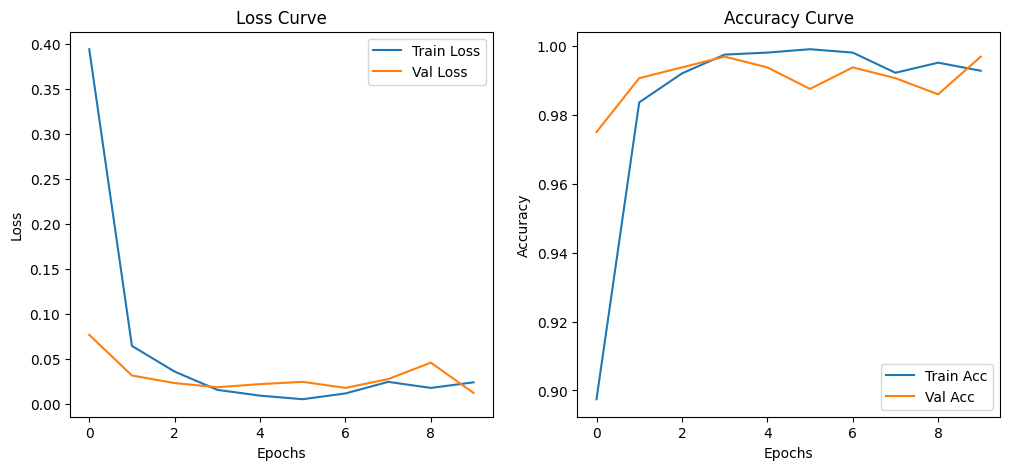

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()

In [7]:
# Classification Report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


DETAILED CLASSIFICATION REPORT
                   precision    recall  f1-score   support

      Anthracnose     0.9855    0.9444    0.9645        72
   Bacterial Wilt     1.0000    1.0000    1.0000        87
        Belly Rot     1.0000    1.0000    1.0000        79
     Downy Mildew     0.9770    1.0000    0.9884        85
   Fresh Cucumber     1.0000    1.0000    1.0000        68
       Fresh Leaf     1.0000    1.0000    1.0000        98
Gummy Stem Blight     0.9706    0.9851    0.9778        67
Pythium Fruit Rot     1.0000    1.0000    1.0000        84

         accuracy                         0.9922       640
        macro avg     0.9916    0.9912    0.9913       640
     weighted avg     0.9922    0.9922    0.9921       640

